In [245]:
%load_ext autoreload
%autoreload 2
from pathlib import Path 
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from glob import glob
import itertools
from functools import lru_cache

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [188]:
def pairwise(iterable):
    # pairwise('ABCDEFG') --> AB BC CD DE EF FG
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)

In [42]:
path_data = Path(f"./Challenge 3 Variation mesures sondes fixes")
network_state_path = path_data / f"Etats reseaux telecoms"

measure_df = pd.read_csv(path_data / f"Mesures_exposition_sondes_autonomes.csv", sep=";")
mse_df = pd.read_csv(path_data / f"Dates_mise-en-service_sondes_autonomes.csv", sep=",")

In [55]:
measure_df["date"]

0         27/02/2020 01:06
1         27/02/2020 01:06
2         27/02/2020 01:06
3         27/02/2020 03:06
4         27/02/2020 03:06
                ...       
419956    05/10/2022 23:06
419957    05/10/2022 23:06
419958    05/10/2022 23:06
419959    05/10/2022 23:06
419960    05/10/2022 23:06
Name: date, Length: 419961, dtype: object

# Enrichissement de `measure_df`

In [78]:
measure_df["datetime"] = [datetime.strptime(d, "%d/%m/%Y %H:%M") for d in measure_df["date"]]
measure_df["weekday"] = [f.weekday() for f in measure_df["datetime"]]
measure_df["month"] = [f.month for f in measure_df["datetime"]]
measure_df["day"] = [f.day for f in measure_df["datetime"]]
measure_df["hour"] = [f.hour for f in measure_df["datetime"]]

In [79]:
measure_df

,E_volt_par_metre,date,ville,code_postal,adresse,numero,latitude,longitude,datetime,weekday,month,day,hour
0,0.93,27/02/2020 01:06,Marseille,13002,66 Avenue Robert Schuman,Marseille_01,43.304390,5.367127,2020-02-27 01:06:00,3,2,27,1
1,0.84,27/02/2020 01:06,Marseille,13006,Cours Pierre Puget,Marseille_02,43.290324,5.374826,2020-02-27 01:06:00,3,2,27,1
2,1.33,27/02/2020 01:06,Marseille,13007,31 Chemin de la Batterie des Lions,Marseille_03,43.281023,5.350082,2020-02-27 01:06:00,3,2,27,1
3,0.81,27/02/2020 03:06,Marseille,13002,66 Avenue Robert Schuman,Marseille_01,43.304390,5.367127,2020-02-27 03:06:00,3,2,27,3
4,0.62,27/02/2020 03:06,Marseille,13006,Cours Pierre Puget,Marseille_02,43.290324,5.374826,2020-02-27 03:06:00,3,2,27,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
419956,1.62,05/10/2022 23:06,Le_Taillan-Médoc,33200,86 Avenue du Stade,Le Taillan-Médoc_01,44.916404,-0.683546,2022-10-05 23:06:00,2,10,5,23
419957,0.26,05/10/2022 23:06,Paris,75008,84 Boulevard Haussmann,Paris_8e_03,48.874211,2.324807,2022-10-05 23:06:00,2,10,5,23
419958,0.98,05/10/2022 23:06,Mulhouse,68200,3 Rue Henri Dunant,Mulhouse_02,47.770411,7.320358,2022-10-05 23:06:00,2,10,5,23
419959,0.75,05/10/2022 23:06,Strasbourg,67000,Rue du 22 Novembre,Strasbourg_01,48.582774,7.745277,2022-10-05 23:06:00,2,10,5,23


In [29]:
network_state_dict = {}
for path in network_state_path.glob("*.csv"):
    date = path.name.split("_Etat reseaux.csv")[0]
    network_state_dict[date] = pd.read_csv(path.absolute(), sep=";")

In [32]:
print(f"les dates disponibles : {tuple(network_state_dict.keys())}")

les dates disponibles : ('2020_03_31', '2020_06_30', '2020_09_30', '2020_12_31', '2021_03_31', '2021_06_30', '2021_09_30', '2021_12_31', '2022_03_31', '2022_06_30', '2022_09_30')


In [30]:
network_state_dict["2020_03_31"]

,EMETTEUR ID,DATE MES EMETTEUR,SYSTEME TELECOM,GENERATION TELECOM,ANTENNE ID,AZIMUT ANTENNE,ALTITUDE ANTENNE,NUM STATION ANFR,OPERATEUR,ID SUPPORT,...,COR_NB_MN_LAT,COR_NB_SC_LAT,COR_CD_NS_LAT,COR_NB_DG_LON,COR_NB_MN_LON,COR_NB_SC_LON,COR_CD_EW_LON,LATITUDE DD,LONGITUDE DD,NUMERO SONDE FIXE
0,2311395,15/05/1994,GSM 900,2G,239926,150.0,"32,8",132290036,ORANGE,759406,...,17,33,N,5,22,36,E,43.292500,5.376667,Marseille_02
1,2311401,15/05/1994,GSM 900,2G,239928,30.0,"32,8",132290036,ORANGE,759406,...,17,33,N,5,22,36,E,43.292500,5.376667,Marseille_02
2,2311407,15/05/1994,GSM 900,2G,239930,270.0,"32,8",132290036,ORANGE,759406,...,17,33,N,5,22,36,E,43.292500,5.376667,Marseille_02
3,2973898,23/06/1995,GSM 900,2G,2617665,0.0,31,132700319,SFR,449181,...,17,26,N,5,22,26,E,43.290556,5.373889,Marseille_02
4,2973908,23/06/1995,GSM 900,2G,2617667,240.0,31,132700319,SFR,449181,...,17,26,N,5,22,26,E,43.290556,5.373889,Marseille_02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
700,11995457,15/01/2020,UMTS 2100,3G,5713308,260.0,"27,6",442750630,BOUYGUES TELECOM,2136870,...,12,23,N,1,34,27,W,47.206389,-1.574167,Nantes_02
701,11995475,15/01/2020,UMTS 2100,3G,5713310,80.0,"27,6",442750630,BOUYGUES TELECOM,2136870,...,12,23,N,1,34,27,W,47.206389,-1.574167,Nantes_02
702,11995447,15/01/2020,UMTS 900,3G,5713306,350.0,"27,6",442750630,BOUYGUES TELECOM,2136870,...,12,23,N,1,34,27,W,47.206389,-1.574167,Nantes_02
703,11995461,15/01/2020,UMTS 900,3G,5713308,260.0,"27,6",442750630,BOUYGUES TELECOM,2136870,...,12,23,N,1,34,27,W,47.206389,-1.574167,Nantes_02


# Afficher une sonde

In [112]:
sonde = f"Marseille_{1:0>2}"

In [41]:
measure_df

,E_volt_par_metre,date,ville,code_postal,adresse,numero,latitude,longitude
0,0.93,27/02/2020 01:06,Marseille,13002,66 Avenue Robert Schuman,Marseille_01,43.304390,5.367127
1,0.84,27/02/2020 01:06,Marseille,13006,Cours Pierre Puget,Marseille_02,43.290324,5.374826
2,1.33,27/02/2020 01:06,Marseille,13007,31 Chemin de la Batterie des Lions,Marseille_03,43.281023,5.350082
3,0.81,27/02/2020 03:06,Marseille,13002,66 Avenue Robert Schuman,Marseille_01,43.304390,5.367127
4,0.62,27/02/2020 03:06,Marseille,13006,Cours Pierre Puget,Marseille_02,43.290324,5.374826
...,...,...,...,...,...,...,...,...
419956,1.62,05/10/2022 23:06,Le_Taillan-Médoc,33200,86 Avenue du Stade,Le Taillan-Médoc_01,44.916404,-0.683546
419957,0.26,05/10/2022 23:06,Paris,75008,84 Boulevard Haussmann,Paris_8e_03,48.874211,2.324807
419958,0.98,05/10/2022 23:06,Mulhouse,68200,3 Rue Henri Dunant,Mulhouse_02,47.770411,7.320358
419959,0.75,05/10/2022 23:06,Strasbourg,67000,Rue du 22 Novembre,Strasbourg_01,48.582774,7.745277


In [60]:
measure_df[measure_df["numero"]==sonde]

,E_volt_par_metre,date,ville,code_postal,adresse,numero,latitude,longitude,datetime
0,0.93,27/02/2020 01:06,Marseille,13002,66 Avenue Robert Schuman,Marseille_01,43.30439,5.367127,2020-02-27 01:06:00
3,0.81,27/02/2020 03:06,Marseille,13002,66 Avenue Robert Schuman,Marseille_01,43.30439,5.367127,2020-02-27 03:06:00
6,0.90,27/02/2020 07:06,Marseille,13002,66 Avenue Robert Schuman,Marseille_01,43.30439,5.367127,2020-02-27 07:06:00
9,1.16,27/02/2020 09:06,Marseille,13002,66 Avenue Robert Schuman,Marseille_01,43.30439,5.367127,2020-02-27 09:06:00
12,1.34,27/02/2020 11:06,Marseille,13002,66 Avenue Robert Schuman,Marseille_01,43.30439,5.367127,2020-02-27 11:06:00
...,...,...,...,...,...,...,...,...,...
419617,1.17,05/10/2022 15:06,Marseille,13002,66 Avenue Robert Schuman,Marseille_01,43.30439,5.367127,2022-10-05 15:06:00
419690,1.18,05/10/2022 17:06,Marseille,13002,66 Avenue Robert Schuman,Marseille_01,43.30439,5.367127,2022-10-05 17:06:00
419763,1.12,05/10/2022 19:06,Marseille,13002,66 Avenue Robert Schuman,Marseille_01,43.30439,5.367127,2022-10-05 19:06:00
419836,1.11,05/10/2022 21:06,Marseille,13002,66 Avenue Robert Schuman,Marseille_01,43.30439,5.367127,2022-10-05 21:06:00


In [51]:
timestamps = measure_df["date"]
print(len(timestamps))
print(len(set(timestamps)))
print(len(timestamps))


419961
21700


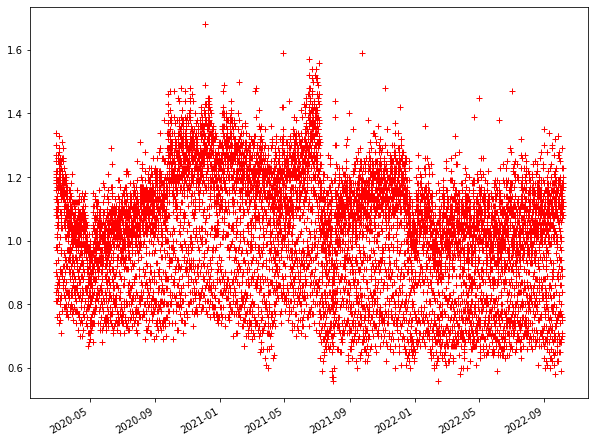

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
DF = pd.DataFrame()
DF['value'] = measure_df[measure_df["numero"]==sonde]["E_volt_par_metre"]
DF = DF.set_index(measure_df[measure_df["numero"]==sonde]["datetime"])
plt.plot(DF, 'r+')
plt.gcf().autofmt_xdate()
plt.show()

In [68]:
dt = measure_df[measure_df["numero"]==sonde]["datetime"][0]
dt.weekday()

3

In [94]:
measure_df["weekday"]==2

0         False
1         False
2         False
3         False
4         False
          ...  
419956     True
419957     True
419958     True
419959     True
419960     True
Name: weekday, Length: 419961, dtype: bool

In [111]:
((measure_df["numero"]==sonde) & (measure_df["weekday"]==2)).sum()

1563

In [118]:
measure_df[(measure_df["numero"]==sonde) & (measure_df["weekday"]==2)]

,E_volt_par_metre,date,ville,code_postal,adresse,numero,latitude,longitude,datetime,weekday,month,day,hour
199,0.99,04/03/2020 01:06,Marseille,13002,66 Avenue Robert Schuman,Marseille_01,43.30439,5.367127,2020-03-04 01:06:00,2,3,4,1
205,0.74,04/03/2020 03:06,Marseille,13002,66 Avenue Robert Schuman,Marseille_01,43.30439,5.367127,2020-03-04 03:06:00,2,3,4,3
211,0.87,04/03/2020 07:06,Marseille,13002,66 Avenue Robert Schuman,Marseille_01,43.30439,5.367127,2020-03-04 07:06:00,2,3,4,7
217,1.18,04/03/2020 09:06,Marseille,13002,66 Avenue Robert Schuman,Marseille_01,43.30439,5.367127,2020-03-04 09:06:00,2,3,4,9
223,1.24,04/03/2020 11:06,Marseille,13002,66 Avenue Robert Schuman,Marseille_01,43.30439,5.367127,2020-03-04 11:06:00,2,3,4,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
419617,1.17,05/10/2022 15:06,Marseille,13002,66 Avenue Robert Schuman,Marseille_01,43.30439,5.367127,2022-10-05 15:06:00,2,10,5,15
419690,1.18,05/10/2022 17:06,Marseille,13002,66 Avenue Robert Schuman,Marseille_01,43.30439,5.367127,2022-10-05 17:06:00,2,10,5,17
419763,1.12,05/10/2022 19:06,Marseille,13002,66 Avenue Robert Schuman,Marseille_01,43.30439,5.367127,2022-10-05 19:06:00,2,10,5,19
419836,1.11,05/10/2022 21:06,Marseille,13002,66 Avenue Robert Schuman,Marseille_01,43.30439,5.367127,2022-10-05 21:06:00,2,10,5,21


evolution sonde Marseille_01 en fonction jour de la semaine


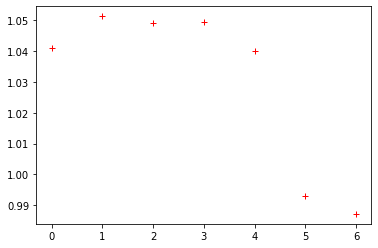

In [129]:
xrange = tuple(range(7))
res = []
for x in xrange:
    res.append(measure_df[(measure_df["numero"]==sonde) & (measure_df["weekday"]==x)]["E_volt_par_metre"].mean())
plt.plot(xrange, res, "r+")
plt.title(f"evolution sonde {sonde} en fonction jour de la semaine")

Text(0.5, 1.0, 'evolution moyenne toutes les sondes en fonction jour de la semaine')

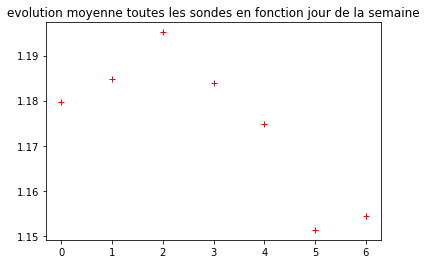

In [132]:
xrange = tuple(range(7))
res = []
for x in xrange:
    res.append(measure_df[(measure_df["weekday"]==x)]["E_volt_par_metre"].mean())
plt.plot(xrange, res, "r+")
plt.title(f"evolution moyenne toutes les sondes en fonction jour de la semaine")

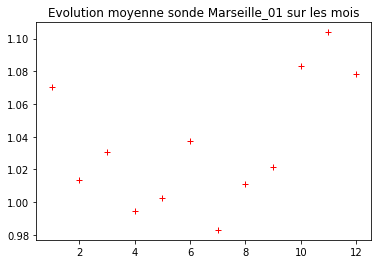

In [141]:
plt.title(f"Evolution moyenne sonde {sonde} sur les mois")
xrange=np.sort(measure_df["month"].unique()) # == range(1, 13)
plt.plot(xrange, [measure_df[(measure_df["numero"]==sonde) & (measure_df["month"]==x)]["E_volt_par_metre"].mean() for x in xrange], "r+")

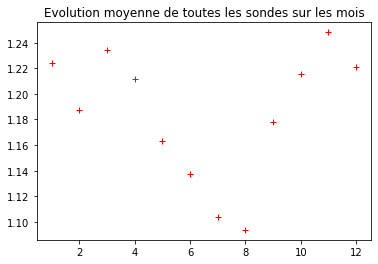

In [148]:
plt.title(f"Evolution moyenne de toutes les sondes sur les mois")
xrange=np.sort(measure_df["month"].unique()) # == range(1, 13)
plt.plot(xrange, [measure_df[(measure_df["month"]==x)]["E_volt_par_metre"].mean() for x in xrange], "r+")

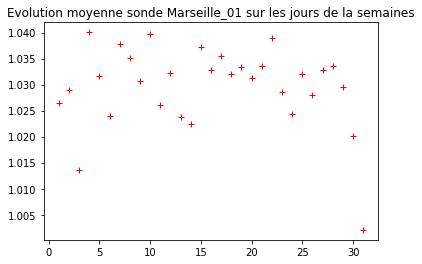

In [154]:
plt.title(f"Evolution moyenne sonde {sonde} sur les jours de la semaines")
xrange=np.sort(measure_df["day"].unique()) # == range(1, 31 + 1)
plt.plot(xrange, [measure_df[(measure_df["numero"]==sonde) & (measure_df["day"]==x)]["E_volt_par_metre"].mean() for x in xrange], "r+")

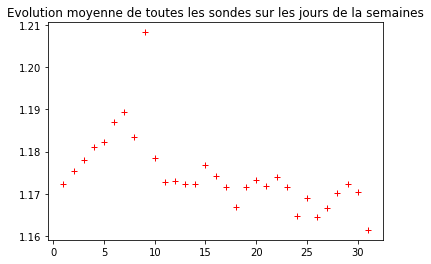

In [158]:
plt.title(f"Evolution moyenne de toutes les sondes sur les jours de la semaines")
xrange=np.sort(measure_df["day"].unique()) # == range(1, 31 + 1)
plt.plot(xrange, [measure_df[(measure_df["day"]==x)]["E_volt_par_metre"].mean() for x in xrange], "r+")

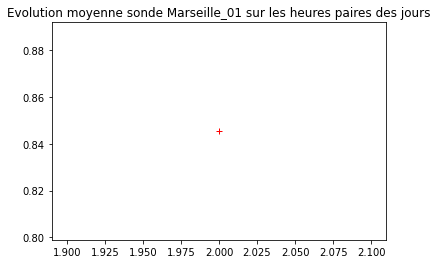

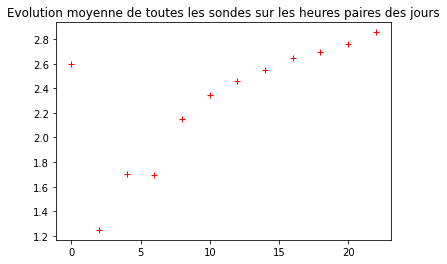

In [180]:
plt.title(f"Evolution moyenne sonde {sonde} sur les heures paires des jours")
xrange = tuple(range(0, 24, 2))
plt.plot(xrange, [measure_df[(measure_df["numero"]==sonde) & (measure_df["hour"]==x)]["E_volt_par_metre"].mean() for x in xrange], "r+")
plt.show()
plt.title(f"Evolution moyenne de toutes les sondes sur les heures paires des jours")
plt.plot(xrange, [measure_df[(measure_df["hour"]==x)]["E_volt_par_metre"].mean() for x in xrange], "r+")

In [170]:
xrange, np.sort(measure_df["hour"].unique()) 

(range(0, 24),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23], dtype=int64))

In [191]:
from itertools import zip_longest

def grouper(iterable, n, fillvalue=None):
    """Collect data into fixed-length chunks or blocks.

    >>> grouper('ABCDEFG', 3, 'x')
    ['ABC', 'DEF', 'Gxx']
    """
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

In [193]:
tuple(grouper(range(24), 2))

((0, 1),
 (2, 3),
 (4, 5),
 (6, 7),
 (8, 9),
 (10, 11),
 (12, 13),
 (14, 15),
 (16, 17),
 (18, 19),
 (20, 21),
 (22, 23))

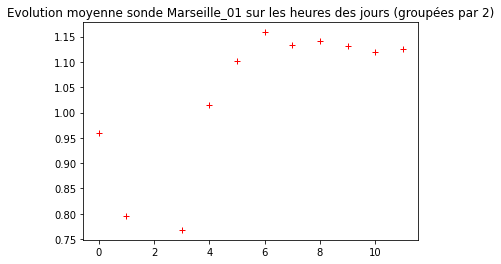

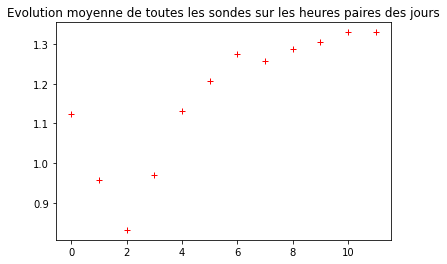

In [199]:
plt.title(f"Evolution moyenne sonde {sonde} sur les heures des jours (groupées par 2)")
bins = tuple(grouper(range(24), 2))
xrange = range(len(bins))
plt.plot(xrange, [measure_df[(measure_df["numero"]==sonde) & ((measure_df["hour"]==bin_[0]) | (measure_df["hour"]==bin_[1]))]["E_volt_par_metre"].mean() for bin_ in bins], "r+")
plt.show()
plt.title(f"Evolution moyenne de toutes les sondes sur les heures paires des jours (groupées par 2)")
plt.plot(xrange, [measure_df[((measure_df["hour"]==bin_[0]) | (measure_df["hour"]==bin_[1]))]["E_volt_par_metre"].mean() for bin_ in bins], "r+")
plt.xlabel()

In [ ]:
plt.figure(figsize=(15, 4))
plt.title(f"Evolution sur l'année au jour près pour la sonde {sonde}")
xrange = tuple(range(365*12))
@lru_cache(maxsize=128)
def getDayMonthFromidx(idx:int):
    datetime_ = datetime(2020, 1, 1) + idx * timedelta(hours=24) #idx indique le jour de l'année
    return datetime_.day, datetime_.month
day_month = [getDayMonthFromidx(i) for i in xrange]
plt.plot(xrange, [measure_df[(measure_df["numero"]==sonde) & (measure_df["month"]==month) & (measure_df["day"]==day)]["E_volt_par_metre"].mean() for day, month in day_month], "r+")
plt.show()
plt.title(f"Evolution moyenne de toutes les sondes sur les heures paires des jours")
plt.plot(xrange, [measure_df[(measure_df["month"]==month) & (measure_df["day"]==day)]["E_volt_par_metre"].mean() for day, month in day_month], "r+")

In [236]:
plt.figure(figsize=(15, 4))
plt.title(f"Evolution sur l'année au jour près pour la sonde {sonde}")
xrange = tuple(range(365*12))
@lru_cache(maxsize=128)
def getDayMonthFromidx(idx:int):
    datetime_ = datetime(2020, 1, 1) + idx * timedelta(hours=24) #idx indique le jour de l'année
    return datetime_.day, datetime_.month
day_month = [getDayMonthFromidx(i) for i in xrange]
plt.plot(xrange, [measure_df[(measure_df["numero"]==sonde) & (measure_df["month"]==month) & (measure_df["day"]==day)]["E_volt_par_metre"].mean() for day, month in day_month], "r+")
plt.show()
plt.title(f"Evolution moyenne de toutes les sondes sur les heures paires des jours")
plt.plot(xrange, [measure_df[(measure_df["month"]==month) & (measure_df["day"]==day)]["E_volt_par_metre"].mean() for day, month in day_month], "r+")

26

In [165]:
measure_df

,E_volt_par_metre,date,ville,code_postal,adresse,numero,latitude,longitude,datetime,weekday,month,day,hour
0,0.93,27/02/2020 01:06,Marseille,13002,66 Avenue Robert Schuman,Marseille_01,43.304390,5.367127,2020-02-27 01:06:00,3,2,27,1
1,0.84,27/02/2020 01:06,Marseille,13006,Cours Pierre Puget,Marseille_02,43.290324,5.374826,2020-02-27 01:06:00,3,2,27,1
2,1.33,27/02/2020 01:06,Marseille,13007,31 Chemin de la Batterie des Lions,Marseille_03,43.281023,5.350082,2020-02-27 01:06:00,3,2,27,1
3,0.81,27/02/2020 03:06,Marseille,13002,66 Avenue Robert Schuman,Marseille_01,43.304390,5.367127,2020-02-27 03:06:00,3,2,27,3
4,0.62,27/02/2020 03:06,Marseille,13006,Cours Pierre Puget,Marseille_02,43.290324,5.374826,2020-02-27 03:06:00,3,2,27,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
419956,1.62,05/10/2022 23:06,Le_Taillan-Médoc,33200,86 Avenue du Stade,Le Taillan-Médoc_01,44.916404,-0.683546,2022-10-05 23:06:00,2,10,5,23
419957,0.26,05/10/2022 23:06,Paris,75008,84 Boulevard Haussmann,Paris_8e_03,48.874211,2.324807,2022-10-05 23:06:00,2,10,5,23
419958,0.98,05/10/2022 23:06,Mulhouse,68200,3 Rue Henri Dunant,Mulhouse_02,47.770411,7.320358,2022-10-05 23:06:00,2,10,5,23
419959,0.75,05/10/2022 23:06,Strasbourg,67000,Rue du 22 Novembre,Strasbourg_01,48.582774,7.745277,2022-10-05 23:06:00,2,10,5,23


In [75]:
# network_state_df = 

In [108]:
dfs = []
for date, df in network_state_dict.items():
    df["date"] = date
    dfs.append(df)
network_state_df = pd.concat(dfs)
network_state_df.head()

705
711
707
3182
4098
5478
7013
7392
8444
9520
9447
56697 56697


In [202]:
antennas = list(set(network_state_df["EMETTEUR ID"]))
print(len(antennas), "émetteurs distincts")

sondes = list(set(measure_df["numero"]))
print(len(sondes), "sondes distinctes")

9832 émetteurs distincts
75 sondes distinctes


In [218]:
datetimes = list(set(measure_df["datetime"]))
print(len(datetimes), "datetimes distincts")
trimesters = list(sorted(set(network_state_dict.keys()))
print(trimesters)

21700 datetimes distincts
['2020_03_31', '2020_06_30', '2020_09_30', '2020_12_31', '2021_03_31', '2021_06_30', '2021_09_30', '2021_12_31', '2022_03_31', '2022_06_30', '2022_09_30']


In [223]:
activity_df = pd.DataFrame(columns=antennas, index=trimesters).fillna(0).astype(bool)
activity_df

,1998859,1998861,1998863,1998865,1998867,1998869,17334310,17334312,17334314,1998895,...,3145615,3538842,3538844,3538846,3538848,3538850,3538852,9371599,9371601,9371603
2021_03_31,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2022_09_30,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020_03_31,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2022_06_30,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2021_06_30,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020_12_31,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020_09_30,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2021_09_30,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020_06_30,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2022_03_31,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
for trimester in trimesters:
    for antenna in antennas:
        # print(list(network_state_dict[trimester]["EMETTEUR ID"]))
        if antenna in list(network_state_dict[trimester]["EMETTEUR ID"]):
            activity_df[antenna][trimester] = True
activity_df

In [242]:
activity_df_t = activity_df.transpose()
activity_df_t

,2021_03_31,2022_09_30,2020_03_31,2022_06_30,2021_06_30,2020_12_31,2020_09_30,2021_09_30,2020_06_30,2022_03_31,2021_12_31
1998859,False,True,False,True,False,False,False,False,False,False,False
1998861,False,True,False,True,False,False,False,False,False,False,False
1998863,False,True,False,True,False,False,False,False,False,False,False
1998865,False,True,False,True,False,False,False,False,False,False,False
1998867,False,True,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
3538850,False,True,False,True,False,False,False,True,False,True,True
3538852,False,True,False,True,False,False,False,True,False,True,True
9371599,False,True,False,True,False,False,False,True,False,True,True
9371601,False,True,False,True,False,False,False,True,False,True,True
